In [1]:
import pandas as pd
import os
from qc_metrics import extract_af_metrics
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/isdata/winthergrp/zpf738/miniconda3/envs/alphafold/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RECEPTOR_CSV_PATH = 'data/human_receptors.csv'
PREDICTION_DIR = '../predictions_pdb_benchmark'

In [3]:
df_receptors = pd.read_csv(RECEPTOR_CSV_PATH)
df_receptors = df_receptors.loc[~df_receptors['is_single_tm']]
df_receptors = df_receptors.loc[df_receptors['Sequence'].str.len()<=2000]
df_receptors.shape

(1112, 6)

In [5]:
# list all predictions
predictions = os.listdir(PREDICTION_DIR)

n_jobs = 35
with ProcessPoolExecutor(n_jobs) as executor:
    jobs = {}
    for f in tqdm(predictions, leave=False):
        p = os.path.join(PREDICTION_DIR, f)
        file_protein_id = p.split('/')[-1].split('_')[0]
        if file_protein_id not in df_receptors['protein_id'].values:
            continue

        topology = df_receptors.loc[df_receptors['protein_id']==file_protein_id].iloc[0]['Topology']

        job = executor.submit(extract_af_metrics,p, receptor_chains = [0], ligand_chains = [1], receptor_topology_string=topology, relaxed=False, pred_is_nested=False)

        jobs[p] = job

    failed_runs = []
    res = []
    for p, job in tqdm(jobs.items(), leave=True):
        if job.exception() is not None:
            print(p)
            print(job.exception())
            continue
            
        df = job.result()
        if len(df) == 0:
            failed_runs.append(p)
            continue

        s = df.reset_index() # make a new column that contains 1,2,3,4,5 model num
        s['pred_folder'] = df['pred_folder'][0].split('/')[-1]
            
        res.append(s)

df = pd.concat(res)

tmp = df['pred_folder'].str.split('_', expand=True)
df['receptor'] = tmp[0]
df['peptide'] = tmp[1]
df = df.set_index(['peptide', 'receptor', 'index'])

100%|██████████| 1/1 [00:24<00:00, 24.81s/it]         


In [9]:
df.to_pickle('tempsave_raw_df.pkl')

In [26]:
df = pd.read_pickle('tempsave_raw_df.pkl')

In [29]:
df.sort_index().to_csv('results/pdb_benchmark_raw.csv')

In [10]:
def get_ranks(df, true_name, percentiles=True, outside_only=True):

    df = df.copy()
    # mask by contacts
    if outside_only:
        df.loc[df['contacts_outside']==0, 'PAE'] = 1000
        df.loc[df['contacts_outside']==0, 'plddt_ligand'] = -1000
        df.loc[df['contacts_outside']==0, 'ranking_confidence'] = -1000
        df.loc[df['contacts_outside']==0, 'pdockq'] = -1000

        df.loc[df['contacts_outside']==0, 'ptm'] = -1000
        df.loc[df['contacts_outside']==0, 'iptm'] = -1000

    out = pd.Series({
        'PAE': df['PAE'].rank(ascending=True, pct=percentiles)[true_name],
        'plddt': df['plddt_ligand'].rank(ascending=False, pct=percentiles)[true_name],
        'ranking_confidence': df['ranking_confidence'].rank(ascending=False, pct=percentiles)[true_name],
        'pdockq': df['pdockq'].rank(ascending=False, pct=percentiles)[true_name],
        'ptm': df['ptm'].rank(ascending=False, pct=percentiles)[true_name],
        'iptm': df['iptm'].rank(ascending=False, pct=percentiles)[true_name],
    })
    out.name = 'percentile' if percentiles else 'rank'

    return out * (100 if percentiles else 1) # is percent

In [39]:
df_median = df.groupby(level=[0,1]).median()

In [40]:
df_median.groupby(level=0).size()

peptide
P01178:20-28      1112
P01286:32-75      1112
P01303:29-64      1112
P01350:76-92      1112
P06307:96-103     1112
P09683:28-54      1112
P20366:58-68      1112
P22466:33-62      1112
P61278:103-116    1112
Q9UBU3:24-50      1112
dtype: int64

In [13]:
complexes = {
    'Secretin - SECR': 'P47872_P09683:28-54',
    'Galanin - GALR1': 'P47211_P22466:33-62',
    'Galanin - GALR2': 'O43603_P22466:33-62',
    'Oxytocin - OXYR': 'P30559_P01178:20-28',
    'Cholecystokinin-8 - CCKAR': 'P32238_P06307:96-103',
    'Somatostatin-14 - SSR2': 'P30874_P61278:103-116',
    'Neuropeptide Y - NPYR': 'P25929_P01303:29-64',
    'Ghrelin-27 - GHSR': 'Q92847_Q9UBU3:24-50',
    'Substance P - NK1R': 'P25103_P20366:58-68',
    'Somatoliberin - Q9HB45': 'Q9HB45_P01286:32-75',
    'Gastrin-17 - GASR': 'P32239_P01350:76-92',
}

# split, invert result, convert to pep_id -> rec_id dict
true_pairs = dict([x.split('_')[::-1] for x in complexes.values()])

In [14]:
results_deeptmhmm = []
results_nodeeptmhmm = []
for pep, df in df_median.groupby(level=0):
    true_receptor = true_pairs[pep]
    percentiles = get_ranks(df.droplevel(0), true_receptor, percentiles=True)
    percentiles.name = pep + '_' + true_receptor
    results_deeptmhmm.append(percentiles)

    percentiles = get_ranks(df.droplevel(0), true_receptor, percentiles=True,outside_only=False)
    percentiles.name = pep + '_' + true_receptor
    results_nodeeptmhmm.append(percentiles)

    if pep == 'P22466:33-62':
        true_receptor = 'P47211'
        percentiles = get_ranks(df.droplevel(0), true_receptor, percentiles=True)
        percentiles.name = pep + '_' + true_receptor
        results_deeptmhmm.append(percentiles)

        percentiles = get_ranks(df.droplevel(0), true_receptor, percentiles=True,outside_only=False)
        percentiles.name = pep + '_' + true_receptor
        results_nodeeptmhmm.append(percentiles)


Text(0, 0.5, 'Confidence metric for ranking receptors')

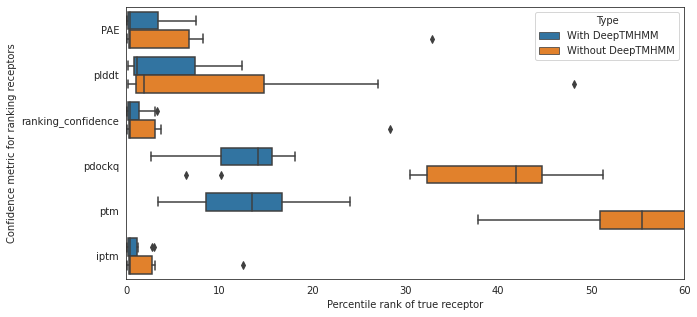

In [15]:
df_with = pd.DataFrame(results_deeptmhmm).melt(ignore_index=False)
df_with['Type'] = 'With DeepTMHMM'
df_without = pd.DataFrame(results_nodeeptmhmm).melt(ignore_index=False)
df_without['Type'] = 'Without DeepTMHMM'

fig = plt.figure(figsize = (10,5))
#pd.concat([df_with, df_without])#.plot.box(by='Type', rot=90)

#sns.violinplot(data=pd.concat([df_with, df_without]), x='variable', y='value', hue='Type', cut=0, inner='point')p
sns.set_style('white')
sns.boxplot(data=pd.concat([df_with, df_without]), y='variable', x='value', hue='Type')
#sns.swarmplot(data=pd.concat([df_with, df_without]), x='variable', y='value', hue='Type')
plt.xlim(0,60)
plt.xlabel('Percentile rank of true receptor')
plt.ylabel('Confidence metric for ranking receptors')

In [16]:
table_for_paper = df_with.reset_index().pivot_table(values='value', columns='variable', index='index')
rename_dict = dict(zip(['_'.join(x.split('_')[::-1]) for x in complexes.values()], complexes.keys()))
table_for_paper.index = [rename_dict[x] for x in table_for_paper.index]
table_for_paper.round(2).sort_index()

variable,PAE,iptm,pdockq,plddt,ptm,ranking_confidence
Cholecystokinin-8 - CCKAR,0.29,0.09,6.47,3.24,18.53,0.09
Galanin - GALR1,0.09,0.09,14.03,0.18,3.42,0.09
Galanin - GALR2,0.46,0.27,18.17,0.74,9.53,0.27
Gastrin-17 - GASR,4.02,1.26,10.88,9.35,15.02,1.89
Ghrelin-27 - GHSR,2.80,1.17,17.00,5.41,7.82,0.99
Neuropeptide Y - NPYR,0.47,0.45,2.70,1.12,5.40,0.45
Oxytocin - OXYR,7.47,2.79,14.21,12.49,19.51,3.15
Secretin - SECR,0.66,0.36,9.44,0.66,13.49,0.36
Somatoliberin - Q9HB45,0.19,0.63,14.30,1.03,14.57,0.63
Somatostatin-14 - SSR2,0.09,0.09,16.10,0.95,9.26,0.09


In [17]:
table_for_paper.mean()

variable
PAE                    1.912710
iptm                   0.923806
pdockq                12.606279
plddt                  4.134117
ptm                   12.786135
ranking_confidence     1.030085
dtype: float64

In [18]:
table_for_paper = df_without.reset_index().pivot_table(values='value', columns='variable', index='index')
rename_dict = dict(zip(['_'.join(x.split('_')[::-1]) for x in complexes.values()], complexes.keys()))
table_for_paper.index = [rename_dict[x] for x in table_for_paper.index]
table_for_paper.round(2).sort_index()

variable,PAE,iptm,pdockq,plddt,ptm,ranking_confidence
Cholecystokinin-8 - CCKAR,0.29,0.09,6.47,3.53,69.51,0.18
Galanin - GALR1,0.09,0.09,35.70,0.18,37.86,0.09
Galanin - GALR2,0.46,0.36,51.26,0.74,54.32,0.27
Gastrin-17 - GASR,32.90,12.59,50.72,48.13,76.17,28.42
Ghrelin-27 - GHSR,8.30,2.52,45.32,11.00,49.73,2.61
Neuropeptide Y - NPYR,0.47,0.45,10.25,1.22,47.39,0.45
Oxytocin - OXYR,7.77,2.97,34.17,27.04,66.82,3.69
Secretin - SECR,3.40,0.45,44.06,0.85,63.85,0.45
Somatoliberin - Q9HB45,0.19,0.63,41.91,1.96,52.25,0.63
Somatostatin-14 - SSR2,0.28,0.36,44.06,1.70,55.49,0.36


In [19]:
table_for_paper.mean()

variable
PAE                    5.444299
iptm                   2.141923
pdockq                35.864944
plddt                 10.453493
ptm                   58.534990
ranking_confidence     3.719751
dtype: float64

In [20]:
import matplotlib

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('afpep', ['#CDDEF7', '#FAD996'])

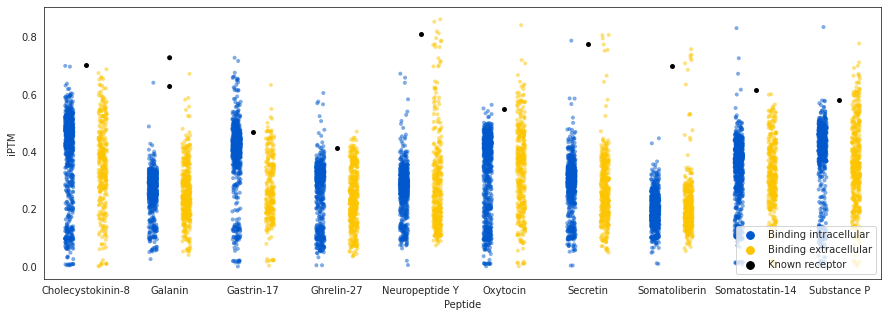

In [22]:
df_plot = df_median.copy().reset_index()
df_plot['contacts_outside'] = df_plot['contacts_outside'].fillna(0)
df_plot['peptide'] = df_plot['peptide'].replace({'P09683:28-54': 'Secretin',
 'P22466:33-62': 'Galanin',
 'P01178:20-28': 'Oxytocin',
 'P06307:96-103': 'Cholecystokinin-8',
 'P61278:103-116': 'Somatostatin-14',
 'P01303:29-64': 'Neuropeptide Y',
 'Q9UBU3:24-50': 'Ghrelin-27',
 'P20366:58-68': 'Substance P',
 'P01286:32-75': 'Somatoliberin',
 'P01350:76-92': 'Gastrin-17'})

df_plot['Label'] = 'Binding intracellular'
df_plot.loc[df_plot['contacts_outside'] > 0, 'Label'] = 'Binding extracellular'
#df_top = df_plot.groupby(['peptide', 'Label']).apply(lambda x: x.nlargest(int(len(x)* 0.01), 'iptm')).reset_index(drop=True)
df_true = df_median.loc[[x.split('_')[::-1] for x in complexes.values()]].reset_index()
df_true['Label'] = 'Known receptor'
df_true['peptide'] = df_true['peptide'].replace({'P09683:28-54': 'Secretin',
 'P22466:33-62': 'Galanin',
 'P01178:20-28': 'Oxytocin',
 'P06307:96-103': 'Cholecystokinin-8',
 'P61278:103-116': 'Somatostatin-14',
 'P01303:29-64': 'Neuropeptide Y',
 'Q9UBU3:24-50': 'Ghrelin-27',
 'P20366:58-68': 'Substance P',
 'P01286:32-75': 'Somatoliberin',
 'P01350:76-92': 'Gastrin-17'})

# remove true from background so no double plotting
df_plot = df_plot.set_index(['peptide', 'receptor'], drop=True).drop(df_true.set_index(['peptide', 'receptor']).index).reset_index()

plt.figure(figsize=(15,5))
sns.stripplot(data=df_plot.sort_values('peptide'), y='iptm', x='peptide', hue='Label', dodge=True, alpha=0.5, size=4, hue_order = ['Binding intracellular', 'Binding extracellular'], palette=['#0058cc', '#fcc500'])#'#9DB7DE', '#FAD997']) # 
sns.swarmplot(data=df_true.sort_values('peptide'), y='iptm', x='peptide', hue='Label', dodge=True, palette=['black'])
plt.ylabel('iPTM')
plt.xlabel('Peptide')
plt.legend(loc='lower right')

plt.savefig('iptm_scores.png',dpi=1200)

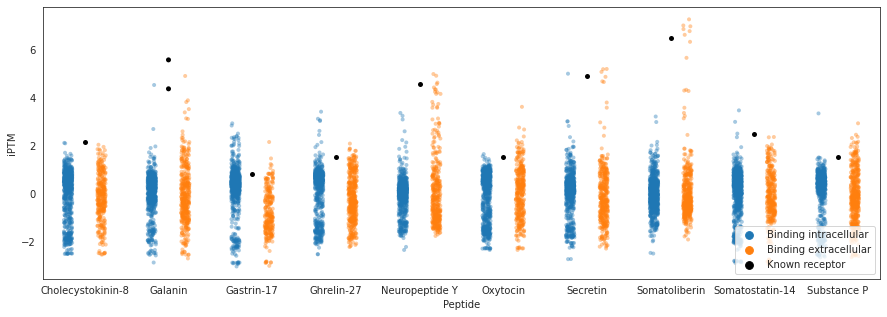

In [55]:
zscore = lambda x: (x - x.mean()) / x.std()
df_plot = df_median.groupby(level=0).transform(zscore)
df_plot['contacts_outside'] = df_median['contacts_outside']
df_plot['contacts_outside'] = df_plot['contacts_outside'].fillna(0)
df_plot = df_plot.reset_index()
df_plot['peptide'] = df_plot['peptide'].replace({'P09683:28-54': 'Secretin',
 'P22466:33-62': 'Galanin',
 'P01178:20-28': 'Oxytocin',
 'P06307:96-103': 'Cholecystokinin-8',
 'P61278:103-116': 'Somatostatin-14',
 'P01303:29-64': 'Neuropeptide Y',
 'Q9UBU3:24-50': 'Ghrelin-27',
 'P20366:58-68': 'Substance P',
 'P01286:32-75': 'Somatoliberin',
 'P01350:76-92': 'Gastrin-17'})


df_plot['Label'] = 'Binding intracellular'
df_plot.loc[df_plot['contacts_outside'] > 0, 'Label'] = 'Binding extracellular'
#df_top = df_plot.groupby(['peptide', 'Label']).apply(lambda x: x.nlargest(int(len(x)* 0.01), 'iptm')).reset_index(drop=True)
df_true = df_median.groupby(level=0).transform(zscore).loc[[x.split('_')[::-1] for x in complexes.values()]].reset_index()
df_true['Label'] = 'Known receptor'
df_true['peptide'] = df_true['peptide'].replace({'P09683:28-54': 'Secretin',
 'P22466:33-62': 'Galanin',
 'P01178:20-28': 'Oxytocin',
 'P06307:96-103': 'Cholecystokinin-8',
 'P61278:103-116': 'Somatostatin-14',
 'P01303:29-64': 'Neuropeptide Y',
 'Q9UBU3:24-50': 'Ghrelin-27',
 'P20366:58-68': 'Substance P',
 'P01286:32-75': 'Somatoliberin',
 'P01350:76-92': 'Gastrin-17'})

# remove true from background so no double plotting
df_plot = df_plot.set_index(['peptide', 'receptor'], drop=True).drop(df_true.set_index(['peptide', 'receptor']).index).reset_index()

plt.figure(figsize=(15,5))
sns.stripplot(data=df_plot.sort_values('peptide'), y='iptm', x='peptide', hue='Label', dodge=True, alpha=0.4, size=4, hue_order = ['Binding intracellular', 'Binding extracellular'])
sns.swarmplot(data=df_true.sort_values('peptide'), y='iptm', x='peptide', hue='Label', dodge=True, palette=['black'])
plt.ylabel('iPTM')
plt.xlabel('Peptide')
plt.legend(loc='lower right')

In [ ]:
# Export data.
df_median = df.groupby(level=[0,1]).median()
df_median['label'] = 'unknown'
df_median.loc[[x.split('_')[::-1] for x in complexes.values()], 'label'] = 'known'
df_median = df_median.reset_index()
df_median['peptide'] = df_median['peptide'].replace({'P09683:28-54': 'Secretin',
 'P22466:33-62': 'Galanin',
 'P01178:20-28': 'Oxytocin',
 'P06307:96-103': 'Cholecystokinin-8',
 'P61278:103-116': 'Somatostatin-14',
 'P01303:29-64': 'Neuropeptide Y',
 'Q9UBU3:24-50': 'Ghrelin-27',
 'P20366:58-68': 'Substance P',
 'P01286:32-75': 'Somatoliberin',
 'P01350:76-92': 'Gastrin-17'})

df_median = df_median.set_index(['peptide', 'receptor'])

df_median.to_csv('results/pdb_benchmark_median.csv')

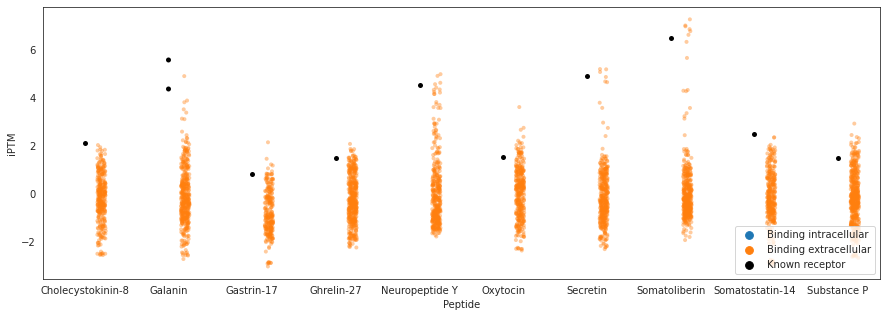

In [56]:
zscore = lambda x: (x - x.mean()) / x.std()
df_plot = df_median.groupby(level=0).transform(zscore)
df_plot['contacts_outside'] = df_median['contacts_outside']
df_plot['contacts_outside'] = df_plot['contacts_outside'].fillna(0)
df_plot = df_plot.loc[df_plot['contacts_outside'] > 0]
df_plot = df_plot.reset_index()
df_plot['peptide'] = df_plot['peptide'].replace({'P09683:28-54': 'Secretin',
 'P22466:33-62': 'Galanin',
 'P01178:20-28': 'Oxytocin',
 'P06307:96-103': 'Cholecystokinin-8',
 'P61278:103-116': 'Somatostatin-14',
 'P01303:29-64': 'Neuropeptide Y',
 'Q9UBU3:24-50': 'Ghrelin-27',
 'P20366:58-68': 'Substance P',
 'P01286:32-75': 'Somatoliberin',
 'P01350:76-92': 'Gastrin-17'})


df_plot['Label'] = 'Binding intracellular'
df_plot.loc[df_plot['contacts_outside'] > 0, 'Label'] = 'Binding extracellular'
#df_top = df_plot.groupby(['peptide', 'Label']).apply(lambda x: x.nlargest(int(len(x)* 0.01), 'iptm')).reset_index(drop=True)
df_true = df_median.groupby(level=0).transform(zscore).loc[[x.split('_')[::-1] for x in complexes.values()]].reset_index()
df_true['Label'] = 'Known receptor'
df_true['peptide'] = df_true['peptide'].replace({'P09683:28-54': 'Secretin',
 'P22466:33-62': 'Galanin',
 'P01178:20-28': 'Oxytocin',
 'P06307:96-103': 'Cholecystokinin-8',
 'P61278:103-116': 'Somatostatin-14',
 'P01303:29-64': 'Neuropeptide Y',
 'Q9UBU3:24-50': 'Ghrelin-27',
 'P20366:58-68': 'Substance P',
 'P01286:32-75': 'Somatoliberin',
 'P01350:76-92': 'Gastrin-17'})

# remove true from background so no double plotting
df_plot = df_plot.set_index(['peptide', 'receptor'], drop=True).drop(df_true.set_index(['peptide', 'receptor']).index).reset_index()

plt.figure(figsize=(15,5))
sns.stripplot(data=df_plot.sort_values('peptide'), y='iptm', x='peptide', hue='Label', dodge=True, alpha=0.4, size=4, hue_order = ['Binding intracellular', 'Binding extracellular'])
sns.swarmplot(data=df_true.sort_values('peptide'), y='iptm', x='peptide', hue='Label', dodge=True, palette=['black'])
plt.ylabel('iPTM')
plt.xlabel('Peptide')
plt.legend(loc='lower right')

In [49]:
df_plot['contacts_outside'] 

0        0.978720
1        2.758171
2        1.868446
3        2.980603
4        2.090877
           ...   
11084    1.310865
11085   -0.683322
11086    0.712609
11087   -0.683322
11088         NaN
Name: contacts_outside, Length: 11089, dtype: float64

In [50]:
df_median['contacts_outside']

peptide       receptor  
P01178:20-28  A0A075B6L2     7.0
              A0A075B6L6    15.0
              A0A075B6N1    11.0
              A0A075B6N2    16.0
              A0A075B6N3    12.0
                            ... 
Q9UBU3:24-50  Q9Y5X5        10.0
              Q9Y5Y3         0.0
              Q9Y5Y4         7.0
              Q9Y653         0.0
              Q9Y6C5         NaN
Name: contacts_outside, Length: 11089, dtype: float64

In [47]:
df_plot.shape

(11089, 11)

In [48]:
df_median.shape

(11089, 9)